In [1]:
import random
import string
import pandas as pd
import numpy as np

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

## Loading the data

In [4]:
df = pd.read_csv('final.csv')

In [5]:
print df.head()

                                             Summary  label
0  Unknown suspects entered into several possible...      2
1  A staff member reported that a computer monito...      2
2                       A suspect removed a bicycle.      2
3  A student reported that another student posted...      2
4  A student reported that a suspect is sharing n...      2


In [6]:
df_1K = df

In [7]:
print df_1K['label'].value_counts()

2    838
3    237
1    166
4     47
5      5
Name: label, dtype: int64


### BOW - Count Vectorization

In [8]:
count_vect = CountVectorizer()

In [9]:
X_train_counts = count_vect.fit_transform(df_1K['Summary'])

In [10]:
print X_train_counts.shape

(1293, 1682)


### TF-IDF

In [11]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

In [12]:
X_train_tf = tf_transformer.transform(X_train_counts)

In [13]:
print X_train_tf.shape

(1293, 1682)


In [14]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print X_train_tfidf.shape

(1293, 1682)


### Classification

In [15]:
clf = MultinomialNB().fit(X_train_tfidf, df_1K['label'])

In [16]:
docs_new = ['A suspect smashed the rear window to gain entry and ransacked the interior, but did not remove any property.']

In [17]:
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)

In [18]:
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, category))

'A suspect smashed the rear window to gain entry and ransacked the interior, but did not remove any property.' => 2


### Pipeline

In [90]:
# Multinomial NB
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df_1K['Summary'], df_1K['label'], test_size=0.3, stratify = df_1K['label'])

In [92]:
text_clf.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...False,
         use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

#### Results

In [93]:
predicted = text_clf.predict(X_test)
#np.mean(predicted == y_test) 

In [94]:
print accuracy_score(y_test, predicted)

0.7319587628865979


In [95]:
print classification_report(y_test, predicted)

             precision    recall  f1-score   support

          1       1.00      0.20      0.33        50
          2       0.71      1.00      0.83       251
          3       1.00      0.32      0.49        71
          4       0.00      0.00      0.00        14
          5       0.00      0.00      0.00         2

avg / total       0.77      0.73      0.67       388



#### ROC

In [96]:
y_testt = []
for item in y_test:
    if(item == 1):
        y_testt.append([1,0,0,0,0])
    if(item == 2):
        y_testt.append([0,1,0,0,0])
    if(item == 3):
        y_testt.append([0,0,1,0,0])
    if(item == 4):
        y_testt.append([0,0,0,1,0])
    if(item == 5):
        y_testt.append([0,0,0,0,1])

In [97]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

In [98]:
y_testt = np.array(y_testt)

In [100]:
y_score = text_clf.predict_proba(X_test)

In [101]:
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_testt[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

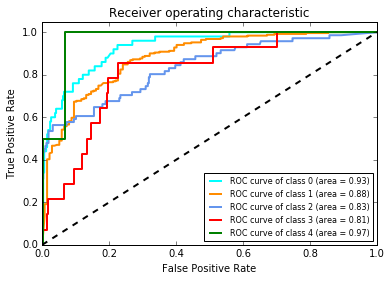

In [70]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_testt.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 5
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
'''
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
'''

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red','green'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

## SVM

In [73]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None)),
])

In [74]:
text_clf.fit(X_train, y_train)
#print('Prediction')
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.8118556701030928

In [ ]:
# Results

In [75]:
print metrics.classification_report(y_test, predicted)

             precision    recall  f1-score   support

          1       0.85      0.66      0.74        50
          2       0.82      0.94      0.88       251
          3       0.78      0.61      0.68        71
          4       0.50      0.21      0.30        14
          5       0.00      0.00      0.00         2

avg / total       0.80      0.81      0.80       388



In [76]:
metrics.confusion_matrix(y_test, predicted)

array([[ 33,  16,   1,   0,   0],
       [  5, 236,   9,   1,   0],
       [  1,  26,  43,   1,   0],
       [  0,   9,   2,   3,   0],
       [  0,   1,   0,   1,   0]], dtype=int64)

### Parameter Tuning

In [77]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

In [78]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, iid=False, n_jobs=-1)

In [79]:
gs_clf = gs_clf.fit(df['Summary'], df['label'])

In [80]:
gs_clf.predict(['A suspect smashed the rear window to gain entry and ransacked the interior, but did not remove any property.'])

array([2], dtype=int64)

In [81]:
gs_clf.best_score_  

0.7997412745659588

In [82]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [ ]:
#gs_clf.cv_results_

#### ROC

In [83]:
y_testt = []
for item in y_test:
    if(item == 1):
        y_testt.append([1,0,0,0,0])
    if(item == 2):
        y_testt.append([0,1,0,0,0])
    if(item == 3):
        y_testt.append([0,0,1,0,0])
    if(item == 4):
        y_testt.append([0,0,0,1,0])
    if(item == 5):
        y_testt.append([0,0,0,0,1])

In [84]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

In [85]:
y_testt = np.array(y_testt)

In [87]:
y_score = text_clf.decision_function(X_test)

In [88]:
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_testt[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

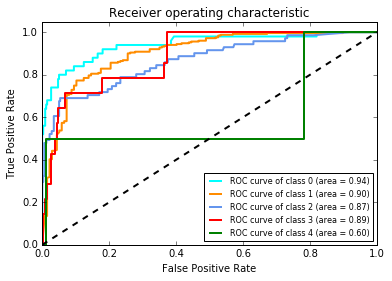

In [89]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_testt.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 5
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
'''
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
'''

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red','green'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()